# StyleCLIP

## StyleCLIP: Text-Driven Image Manipulation with StyleGAN

### **Key Concepts**
- **Combines StyleGAN with CLIP (Contrastive Language-Image Pretraining)** to enable **text-based image editing**.
- Modifies **StyleGAN’s latent space** based on natural language descriptions.

### **Main Approaches**
1. **Latent Optimization** – Directly optimizes the latent code to match the text prompt.  
2. **Latent Mapper** – Uses an additional network to adjust the latent code.  
3. **Direct StyleGAN Weight Modification** – Alters generator layers for text-aligned outputs.  

### **Advantages**
✅ Enables **semantic image editing** (e.g., "make the person look older").  
✅ Works on **pretrained StyleGAN models** without retraining.  
✅ Produces **high-quality edits** while preserving details.  

### **Limitations**
❌ **Constrained by StyleGAN's latent space**, limiting certain transformations.  
❌ **Fine control can be challenging** compared to manual latent manipulation.  


In [1]:
#@title Setup
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force


%cd
%cd /content/

! pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
! git clone https://github.com/orpatashnik/StyleCLIP

os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp

%load_ext autoreload
%autoreload 2
%matplotlib inline


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.0+cu121.with.pypi.cudnn, 2.1.0+rocm5.5, 2.1.0+rocm5.6, 2.1.1, 2.1.1+cpu, 2.1.1+cpu.cxx11.abi, 2.1.1+cu118, 2.1.1+cu121, 2.1.1+cu121.with.pypi.cudnn, 2.1.1+rocm5.5, 2.1.1+rocm5.6, 2.1.2, 2.1.2+cpu, 2.1.2+cpu.cxx11.abi, 2.1.2+cu118, 2.1.2+cu121, 2.1.2+cu121.with.pypi.cudnn, 2.1.2+rocm5.5, 2.1.2+rocm5.6, 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


# Select dataset

In [2]:
dataset_name='ffhq'

%cd
%cd /content/StyleCLIP/global_torch/

if not os.path.isfile('./model/'+dataset_name+'.pkl'):
        url='https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/'
        name='stylegan2-'+dataset_name+'-config-f.pkl'
        os.system('wget ' +url+name + '  -P  ./model/')
        os.system('mv ./model/'+name+' ./model/'+dataset_name+'.pkl')


# input prepare data
import clip
from manipulate import Manipulator
from StyleCLIP import GetDt,GetBoundary


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device,jit=False)

network_pkl='./model/'+dataset_name+'.pkl'
device = torch.device('cuda')
M=Manipulator()
M.device=device
G=M.LoadModel(network_pkl,device)
M.G=G
M.SetGParameters()
num_img=100_000
M.GenerateS(num_img=num_img)
M.GetCodeMS()
np.set_printoptions(suppress=True)

file_path='./npy/'+dataset_name+'/'
fs3=np.load(file_path+'fs3.npy')


/root
/content/StyleCLIP/global_torch


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 108MiB/s]


name:conv1_resolution_4 Resolution: 4, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_4 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_8 Resolution: 8, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_8 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_16 Resolution: 16, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_16 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_32 Resolution: 32, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_32 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:conv1_resolution_64 Resolution: 64, InC: 512, OutC:512, w_dim: 512
name:toRGB_resolution_64 InC: 512, OutC:3, w_dim: 512
name:conv0_resolution_128 Resolution: 128, InC: 512, OutC:256, w_dim: 512
name:conv1_resol

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


# Upload an Image
This section can be skipped if you prefer to edit generated image.

In [3]:
#@title e4e setup
from gdown import download as drive_download
drive_download("https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P", "/content/encoder4editing/e4e_ffhq_encode.pt", quiet=False)
experiment_type = 'ffhq_encode'

os.chdir('/content/encoder4editing')

EXPERIMENT_ARGS = {
        "model_path": "e4e_ffhq_encode.pt"
    }
EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Downloading...
From (original): https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P
From (redirected): https://drive.google.com/uc?id=1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P&confirm=t&uuid=9aaca9c8-254c-401f-af37-dc6bf0c92cb4
To: /content/encoder4editing/e4e_ffhq_encode.pt
100%|██████████| 1.20G/1.20G [00:31<00:00, 37.8MB/s]
<ipython-input-3-d7cb247c99f8>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

Loading e4e over the pSp framework from checkpoint: e4e_ffhq_encode.pt


/content/encoder4editing/models/psp.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.opts.checkpoint_path, map_location='cpu')


Model successfully loaded!


In [4]:
!pwd

/content/encoder4editing


--2025-02-09 19:18:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-02-09 19:18:08--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.0MB/s    in 4.4s    

2025-02-09 19:18:13 (14.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


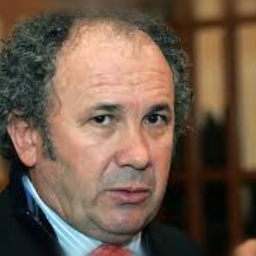

In [6]:
#@title Align image
image_path = "notebooks/images/kerum2.jpg" #@param {type: "string"}
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

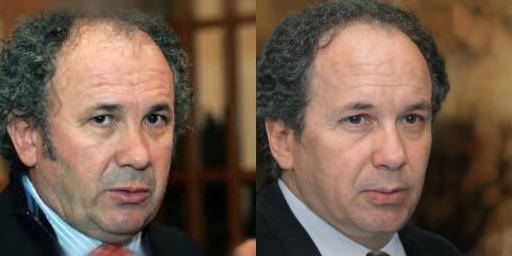

In [7]:
#@title Invert the image
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
torch.save(latents, 'latents.pt')

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)




# Choose Image Index
Relevant only when editing generated image


In [ ]:
img_index =  1#@param {type:"number"}

# Choose Mode (and show input image)
Run for both real and generated image

Setting up PyTorch plugin "upfirdn2d_plugin"... 

<ipython-input-8-7c021d4a234e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latents=torch.load('/content/encoder4editing/latents.pt')
/usr/local/lib/python3.11/dist-pack

Done.


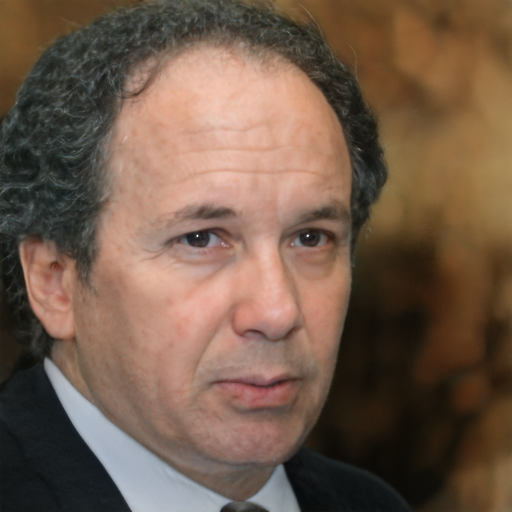

In [8]:
mode='real image' #@param ['real image', 'generated image']

if mode == 'real image':
  img_index = 0
  latents=torch.load('/content/encoder4editing/latents.pt')
  dlatents_loaded=M.G.synthesis.W2S(latents)

  img_indexs=[img_index]
  dlatents_loaded=M.S2List(dlatents_loaded)

  dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
elif mode == 'generated image':
  img_indexs=[img_index]
  dlatents_loaded=M.S2List(dlatents_loaded)
  dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp)
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original


# input text description
For example

| Edit           | Neutral Text       | Target Text                |
|--------------|------------------|---------------------------|
| Beard        | face             | face with a beard        |
| Glasses      | face             | face with glasses        |
| Older Age    | young face       | elderly face             |
| Makeup       | bare face        | face with makeup         |
| Hat          | face             | face with a hat          |
| Curly Hair   | face with hair   | face with curly hair     |
| Wider Nose   | nose             | face with a wider nose   |


In [9]:
neutral='male face' #@param {type:"string"}
target='female smiling face' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.505


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

num of channels being manipulated: 297


(-0.5, 1023.5, 1023.5, -0.5)

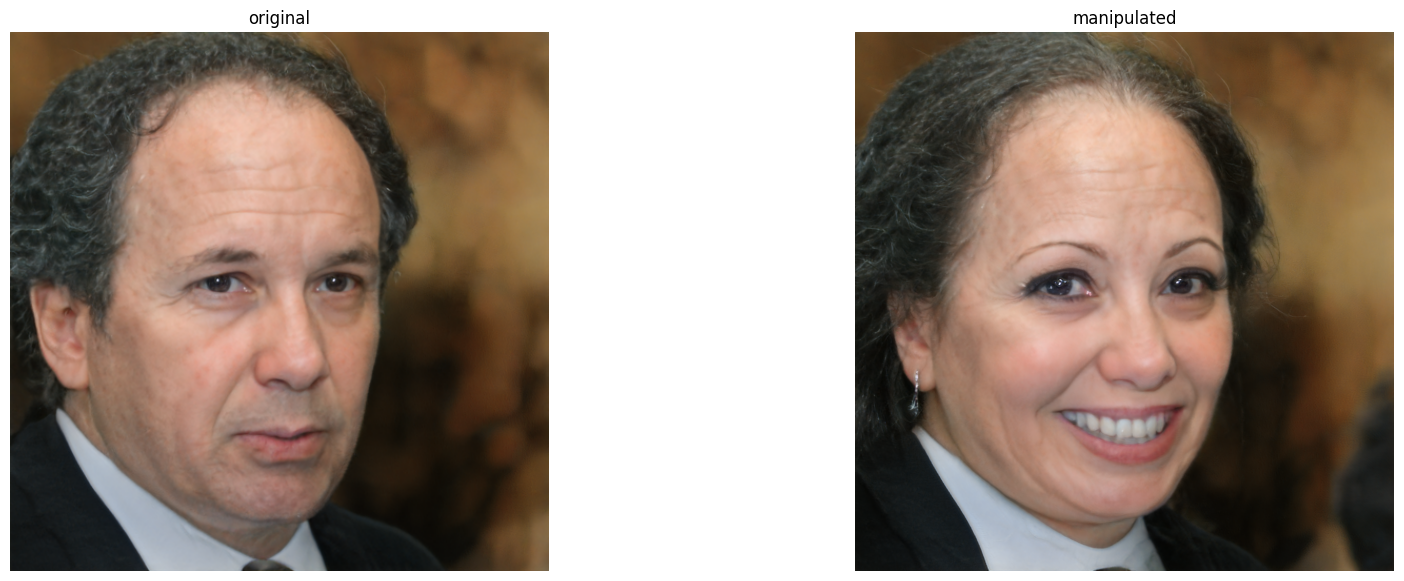

In [13]:

#beta=0.1
#alpha=1
beta = 0.13 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 3 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')

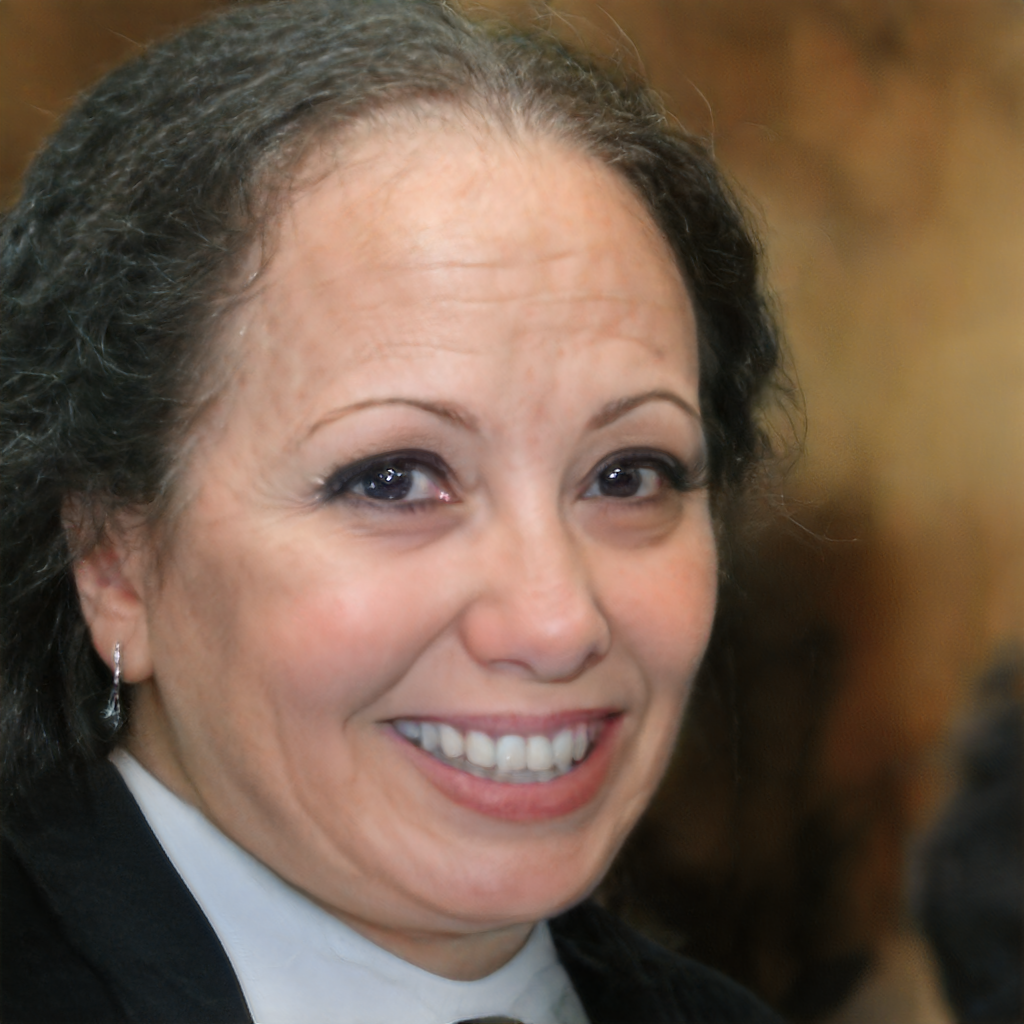

In [14]:
#@title generate a high-res manipulated photo for download
generated

# video

Renders a video interpolating from the base image with provided `beta` to the `target_alpha`. (`target_alpha` can be positive or negative)

In [15]:
from contextlib import contextmanager
import sys, os
from tqdm.notebook import tqdm

beta =  0.13 #@param {type:"number"}
target_alpha =  3.3#@param {type:"number"}
num_frames = 350 #@param {type:"number"}
frame_rate = 60 #@param {type:"number"}

!rm -rf /content/results
!mkdir /content/results

# Mute GetBoundary()
# https://stackoverflow.com/a/25061573
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def gen_image(beta, alpha, i):
  M.alpha=[alpha]
  with suppress_stdout():
    boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
  codes=M.MSCode(dlatent_tmp,boundary_tmp2)
  out=M.GenerateImg(codes)
  Image.fromarray(out[0,0]).save(f"/content/results/{i:04d}.png")

alphas = np.linspace(0, target_alpha, num_frames)

print("Generating Frames:")
for i, alpha in tqdm(enumerate(alphas), total=num_frames):
  gen_image(beta, alpha, i)

print("Rendering Video...")
result = os.system(f"ffmpeg -y -r {frame_rate} -i /content/results/%04d.png -c:v libx264 -vf fps={frame_rate} -pix_fmt yuv420p /content/styleclip.mp4")
print("Video saved at styleclip.mp4!")

from google.colab import files
files.download('/content/styleclip.mp4')

Generating Frames:


  0%|          | 0/350 [00:00<?, ?it/s]

Rendering Video...
Video saved at styleclip.mp4!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>